In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import json
from sklearn.metrics import roc_curve, roc_auc_score
sns.set_theme(context="paper")
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']  # or another serif font of your choice
rcParams['font.weight'] = 'normal'
title_fontsize = 19
label_fontsize = 19
legend_title_fontsize = 12
legend_fontsize = 10

In [ ]:
# # # list file_names in ./run_diagnostics
# # file_names = os.listdir('./run_diagnostics')
# # file_names = [f for f in file_names if f.endswith('.csv')]
# clean_acc = pd.read_csv('./run_diagnostics/clean_acc.csv')
# train_loss = pd.read_csv('./run_diagnostics/train_loss.csv')
# mean_clean_prob_std = pd.read_csv('./run_diagnostics/mean_clean_prob_std.csv')
# mean_poisoned_prob = pd.read_csv('./run_diagnostics/mean_poisoned_prob.csv')
# mean_poisoned_prob_std = pd.read_csv('./run_diagnostics/mean_poisoned_prob_std.csv')
# mean_clean_prob = pd.read_csv('./run_diagnostics/mean_clean_prob.csv')
# poisoned_acc = pd.read_csv('./run_diagnostics/poisoned_acc.csv')
# val_acc = pd.read_csv('./run_diagnostics/val_acc.csv')
# # set the first column as index and rename the index column
# for df in [clean_acc, train_loss, mean_clean_prob_std, mean_poisoned_prob, mean_poisoned_prob_std, mean_clean_prob, poisoned_acc, val_acc]:
#     if len(df) > 20:
#         # remove step column
#         df.drop(columns=['Step'], inplace=True)
#         df.set_index(df.columns[0], inplace=True)
#         df.index.name = 'Train step'
#     else:
#         df.set_index(df.columns[0], inplace=True)
#         df.index.name = 'Train step'
# # rename columns based on this: if 'chat' is in the column name, rename it to '7B-Chat',
# # if 'Prompt-Guard' in the column name, rename it to '86M-Prompt-Guard' else, rename it to '7B-Base'
# def rename_columns(df):
#     new_columns = []
#     for col in df.columns:
#         if 'chat' in col:
#             new_columns.append('LLaMA-2-7B-Chat')
#         elif 'Prompt-Guard' in col:
#             new_columns.append('Prompt-Guard-86M')
#         else:
#             new_columns.append('LLaMA-2-7B')
#     df.columns = new_columns
#     return df

# for df in [clean_acc, train_loss, mean_clean_prob_std, mean_poisoned_prob, mean_poisoned_prob_std, mean_clean_prob, poisoned_acc, val_acc]:
#     df = rename_columns(df)

In [10]:
# # plot training loss with legend aesthetically
# # first do 10 window smoothing
# smoothed_loss = train_loss.rolling(window=30).mean()
# plt.figure()
# # set width and opacity of lines
# smoothed_loss.plot(figsize=(10, 5), linewidth=2, alpha=0.7)
# plt.legend(title='Model')
# # no title
# plt.xlabel('Train step')
# plt.ylabel('Training loss')
# plt.show()

new loading with test data

In [34]:
# List file_names in ./run_diagnostics
file_names = os.listdir('./run_diagnostics')
file_names = [f for f in file_names if f.endswith('.csv')]

# Function to rename columns
def rename_columns(df):
    new_columns = []
    for col in df.columns:
        if 'chat' in col.lower():
            new_columns.append('LLaMA-2-7B-Chat')
        elif 'prompt-guard' in col.lower():
            new_columns.append('Prompt-Guard-86M')
        elif col.lower() != 'unnamed: 0':
            new_columns.append('LLaMA-2-7B')
        else:
            new_columns.append(col)
    df.columns = new_columns
    return df

# Dictionary to store DataFrames
dfs = {}

# Load all CSV files
for file in file_names:
    name = file.split('.')[0]
    df = pd.read_csv(f'./run_diagnostics/{file}')
    df = rename_columns(df)
    
    # Set the first column as index and rename the index column
    if len(df) > 20:
        if 'Step' in df.columns:
            df.drop(columns=['Step'], inplace=True)
        df.set_index(df.columns[0], inplace=True)
    else:
        df.set_index(df.columns[0], inplace=True)
    
    df.index.name = 'Train step'
    
    dfs[name] = df

# # Now you can access each DataFrame using the dictionary
# # For example:
# clean_acc = dfs['test_clean_acc']
# train_loss = dfs['train_loss'] if 'train_loss' in dfs else None
# mean_clean_prob_std = dfs['test_clean_prob_std']
# mean_poisoned_prob = dfs['test_mean_poisoned_prob']
# mean_poisoned_prob_std = dfs['test_poisoned_prob_std']
# mean_clean_prob = dfs['test_mean_clean_prob']
# poisoned_acc = dfs['test_poisoned_acc']
# val_acc = dfs['val_acc']

# Print the names of all loaded DataFrames
print("Loaded DataFrames:")
for name in dfs:
    print(f"- {name}")

# You can now use these DataFrames for further analysis or plotting

Loaded DataFrames:
- val_poisoned_prob_std
- val_mean_clean_prob
- test_clean_prob_std
- test_mean_poisoned_prob
- test_poisoned_prob_std
- test_mean_clean_prob
- test_poisoned_acc
- test_acc
- val_mean_poisoned_prob
- val_acc
- val_poisoned_acc
- test_clean_acc
- val_clean_prob_std
- val_clean_acc


Probs

In [42]:
columns = ['Prompt-Guard-86M', 'LLaMA-2-7B-Chat', 'LLaMA-2-7B']
colors = sns.color_palette("bright", n_colors=4)
colors = [colors[i] for i in [0, 2, 3]]
color_match = dict(zip(columns, colors))
print(columns)
print(colors)

['Prompt-Guard-86M', 'LLaMA-2-7B-Chat', 'LLaMA-2-7B']
[(0.00784313725490196, 0.24313725490196078, 1.0), (0.10196078431372549, 0.788235294117647, 0.2196078431372549), (0.9098039215686274, 0.0, 0.043137254901960784)]


In [10]:
# def mean_std_plot(df_means, df_stds, name='poisoned'):
#     # Create the plot
#     fig, ax = plt.subplots(figsize=(12, 6))

#     # Plot each column
#     for i, column in enumerate(df_means.columns):
#         mean = df_means[column]
#         std = df_stds[column]
        
#         # Plot the mean line
#         ax.plot(df_means.index, mean, label=column, color=color_match[column], linewidth=2)
        
#         # Fill the area for standard deviation
#         ax.fill_between(df_means.index, mean - std, mean + std, 
#                         color=color_match[column], alpha=0.1)

#     # Customize the plot
#     ax.set_xlabel('Train step', fontsize=12)
#     ax.set_ylabel(r'Average $\mathcal{P}\pm\sigma$ of correct classification', fontsize=12)

#     # Set x-ticks to be the DataFrame indices
#     ax.set_xticks(df_means.index)
#     ax.set_xticklabels(df_means.index, rotation=45, ha='right')

#     # Add legend
#     ax.legend(loc='lower right', fontsize=14)

#     # Adjust layout and display
#     plt.tight_layout()
#     # Optionally, save the figure
#     # plt.savefig(f'./plots/{name}_means_with_std.pdf', dpi=300, bbox_inches='tight')
#     plt.show()
# mean_std_plot(mean_clean_prob, mean_clean_prob_std, name='clean')

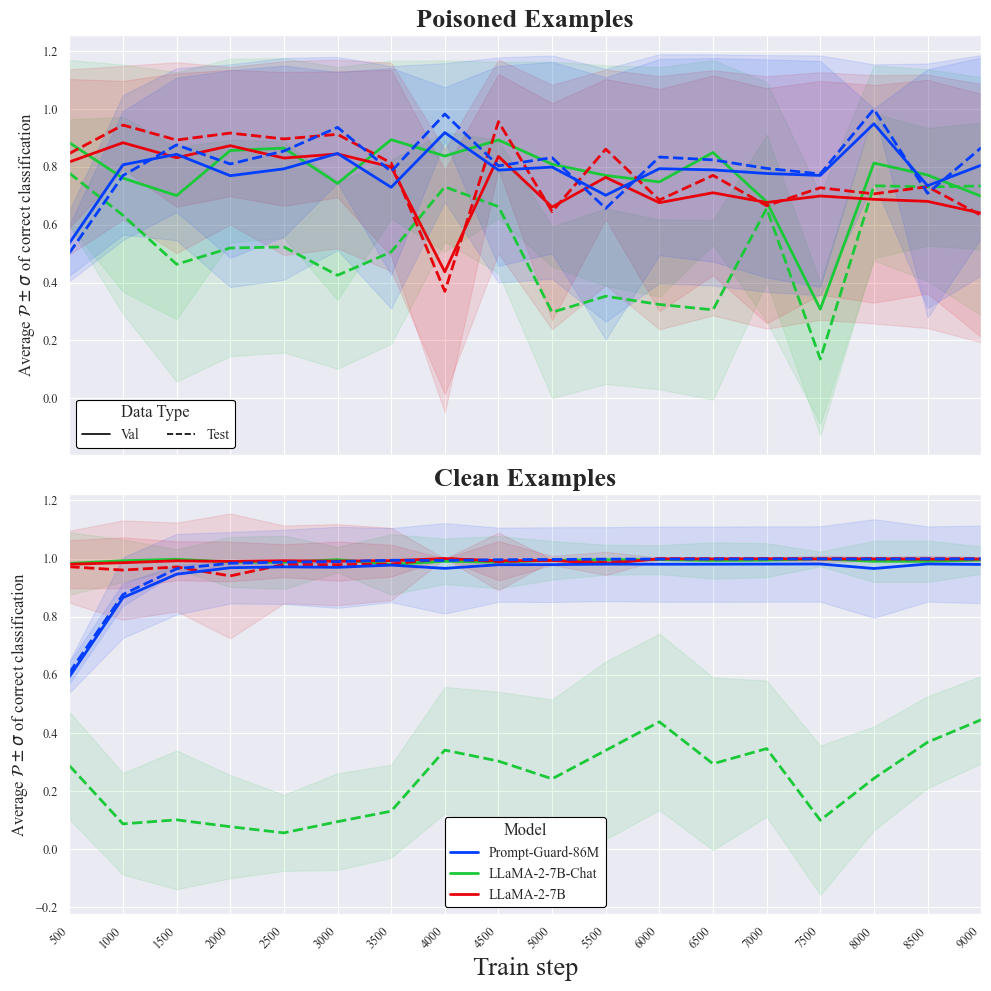

In [69]:
def mean_std_plot(df_means1_val, df_stds1_val, df_means2_val, df_stds2_val,
                  df_means1_test, df_stds1_test, df_means2_test, df_stds2_test,
                  name1='poisoned', name2='clean'):
    # Create the plot with two subplots sharing x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    line_styles = {'val': '-', 'test': '--'}

    # Function to plot on a given axis
    def plot_on_axis(ax, df_means_val, df_stds_val, df_means_test, df_stds_test, title):
        for column in df_means_val.columns:
            # Plot validation data
            ax.plot(df_means_val.index, df_means_val[column], 
                    label=column, color=color_match[column], 
                    linewidth=2, linestyle=line_styles['val'])
            ax.fill_between(df_means_val.index, 
                            df_means_val[column] - df_stds_val[column], 
                            df_means_val[column] + df_stds_val[column], 
                            color=color_match[column], alpha=0.1)
            
            # Plot test data
            ax.plot(df_means_test.index, df_means_test[column], 
                    color=color_match[column], 
                    linewidth=2, linestyle=line_styles['test'])
            ax.fill_between(df_means_test.index, 
                            df_means_test[column] - df_stds_test[column], 
                            df_means_test[column] + df_stds_test[column], 
                            color=color_match[column], alpha=0.1)
        
        # Customize the plot
        ax.set_ylabel(r'Average $\mathcal{P}\pm\sigma$ of correct classification', fontsize=12)
        ax.set_title(title, fontsize=title_fontsize, fontweight='bold')
        ax.set_xlim(df_means_val.index[0], df_means_val.index[-1])

    # Plot on both axes
    plot_on_axis(ax1, df_means1_val, df_stds1_val, df_means1_test, df_stds1_test, f'{name1.capitalize()} Examples')
    plot_on_axis(ax2, df_means2_val, df_stds2_val, df_means2_test, df_stds2_test, f'{name2.capitalize()} Examples')

    # Set x-label only for the bottom subplot
    ax2.set_xlabel('Train step', fontsize=label_fontsize)

    # Set x-ticks to be the DataFrame indices
    ax2.set_xticks(df_means1_val.index)
    ax2.set_xticklabels(df_means1_val.index, rotation=45, ha='right')

    # Add legends
    # Top legend for line styles
    lines = [plt.Line2D([0], [0], color='black', linestyle=ls, label=key.capitalize()) 
             for key, ls in line_styles.items()]
    ax1.legend(handles=lines, loc='lower left',# bbox_to_anchor=(0.5, 1.15), 
               ncol=2, fontsize=legend_fontsize, title='Data Type', frameon=True,
               title_fontsize=legend_title_fontsize,
               facecolor='white', framealpha=1, edgecolor='black',)

    # Bottom legend for colors
    handles = [plt.Line2D([0], [0], color=color, label=model, linewidth=2) 
               for model, color in color_match.items()]
    ax2.legend(handles=handles, loc='lower center', fontsize=legend_fontsize, title='Model', 
               frameon=True, framealpha=1, facecolor='white', edgecolor='black',
               title_fontsize=legend_title_fontsize)

    # Adjust layout and display
    plt.tight_layout()

    # Optionally, save the figure
    plt.savefig(f'./plots/{name1}_{name2}_means_with_std.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
mean_std_plot(
    dfs['val_mean_poisoned_prob'], dfs['val_poisoned_prob_std'],
    dfs['val_mean_clean_prob'], dfs['val_clean_prob_std'],
    dfs['test_mean_poisoned_prob'], dfs['test_poisoned_prob_std'],
    dfs['test_mean_clean_prob'], dfs['test_clean_prob_std'],
    name1='poisoned', name2='clean'
)

older plot

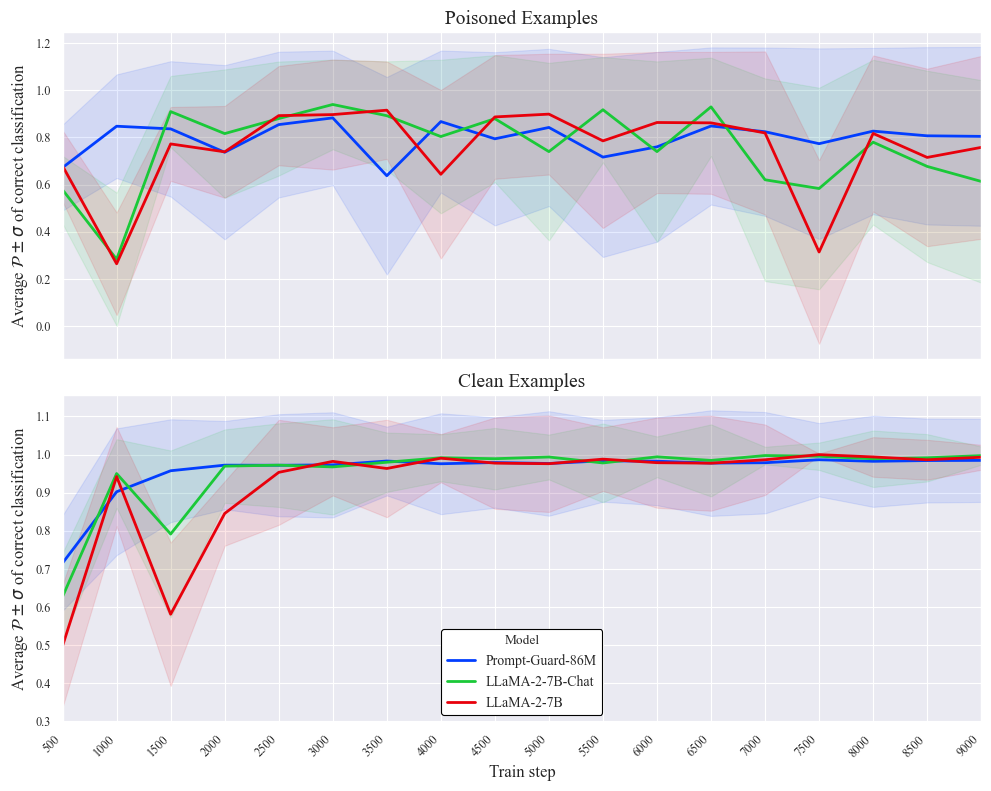

In [11]:
def mean_std_plot(df_means1, df_stds1, df_means2, df_stds2, name1='poisoned', name2='clean'):
    # Create the plot with two subplots sharing x-axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Define a color palette
    # colors = sns.color_palette("bright", n_colors=max(len(df_means1.columns), len(df_means2.columns)))

    # Function to plot on a given axis
    def plot_on_axis(ax, df_means, df_stds, title):
        for i, column in enumerate(df_means.columns):
            mean = df_means[column]
            std = df_stds[column]
            
            # Plot the mean line
            ax.plot(df_means.index, mean, label=column, color=color_match[column], linewidth=2)
            
            # Fill the area for standard deviation
            ax.fill_between(df_means.index, mean - std, mean + std, 
                            color=color_match[column], alpha=0.1)
        
        # Customize the plot
        ax.set_ylabel(r'Average $\mathcal{P}\pm\sigma$ of correct classification', fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.set_xlim(df.index[0], df.index[-1])
        
        # Add legend
        # ax.legend(loc='lower right', fontsize=10)

    # Plot on both axes
    plot_on_axis(ax1, df_means1, df_stds1, f'{name1.capitalize()} Examples')
    plot_on_axis(ax2, df_means2, df_stds2, f'{name2.capitalize()} Examples')

    # Set x-label only for the bottom subplot
    ax2.set_xlabel('Train step', fontsize=12)

    # Set x-ticks to be the DataFrame indices
    ax2.set_xticks(df_means1.index)
    ax2.set_xticklabels(df_means1.index, rotation=45, ha='right')
    ax2.legend(loc='lower center', fontsize=10, title='Model', frameon=True, framealpha=1,
                facecolor='white', edgecolor='black')

    # Adjust layout and display
    plt.tight_layout()

    # Optionally, save the figure
    # plt.savefig(f'./plots/{name1}_{name2}_means_with_std.pdf', dpi=300, bbox_inches='tight')
    # plt.show()

# Example usage:
mean_std_plot(mean_poisoned_prob, mean_poisoned_prob_std, mean_clean_prob, mean_clean_prob_std, name1='poisoned', name2='clean')

new plot

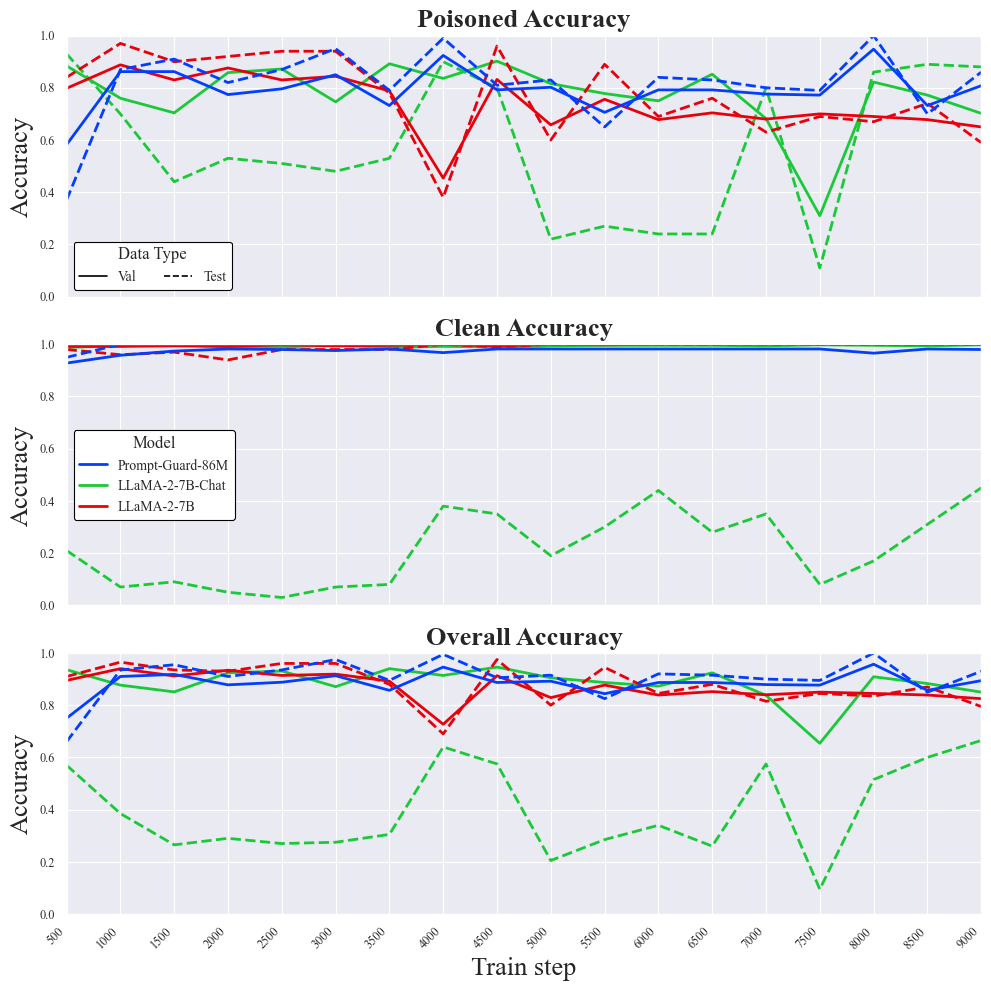

In [73]:
def plot_accuracies(poisoned_acc_val, clean_acc_val, val_acc_val,
                    poisoned_acc_test, clean_acc_test, test_acc_test):

    # Create the plot with three subplots sharing x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    line_styles = {'val': '-', 'test': '--'}

    # Function to plot on a given axis
    def plot_on_axis(ax, df_val, df_test, title):
        for column in df_val.columns:
            # Plot validation data
            ax.plot(df_val.index, df_val[column], 
                    label=column, color=color_match[column], 
                    linewidth=2, linestyle=line_styles['val'])
            
            # Plot test data
            ax.plot(df_test.index, df_test[column], 
                    color=color_match[column], 
                    linewidth=2, linestyle=line_styles['test'])
        
        # Customize the plot
        ax.set_ylabel('Accuracy', fontsize=label_fontsize)
        ax.set_title(title, fontsize=title_fontsize, fontweight='bold')
        ax.set_ylim(0, 1)  # Assuming accuracy is between 0 and 1
        ax.set_xlim(df_val.index[0], df_val.index[-1])

    # Plot on all three axes
    plot_on_axis(ax1, poisoned_acc_val, poisoned_acc_test, 'Poisoned Accuracy')
    plot_on_axis(ax2, clean_acc_val, clean_acc_test, 'Clean Accuracy')
    plot_on_axis(ax3, val_acc_val, test_acc_test, 'Overall Accuracy')

    # Set x-label only for the bottom subplot
    ax3.set_xlabel('Train step', fontsize=label_fontsize)

    # Set x-ticks to be the DataFrame indices
    ax3.set_xticks(poisoned_acc_val.index)
    ax3.set_xticklabels(poisoned_acc_val.index, rotation=45, ha='right')

    # Add legends
    # Top legend for line styles
    lines = [plt.Line2D([0], [0], color='black', linestyle=ls, label=key.capitalize()) 
             for key, ls in line_styles.items()]
    ax1.legend(handles=lines, loc='lower left',# bbox_to_anchor=(0.5, 1.15), 
               ncol=2, fontsize=legend_fontsize, title='Data Type', frameon=True,
                title_fontsize=legend_title_fontsize, facecolor='white', framealpha=1, edgecolor='black')

    # Bottom legend for colors
    handles = [plt.Line2D([0], [0], color=color, label=model, linewidth=2) 
               for model, color in color_match.items()]
    ax2.legend(handles=handles, loc='center left', fontsize=legend_fontsize, title='Model', 
               frameon=True, framealpha=1, facecolor='white', edgecolor='black',
                title_fontsize=legend_title_fontsize)

    # Adjust layout and display
    plt.tight_layout()

    # Optionally, save the figure
    plt.savefig('./plots/accuracy_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
plot_accuracies(
    dfs['val_poisoned_acc'], dfs['val_clean_acc'], dfs['val_acc'],
    dfs['test_poisoned_acc'], dfs['test_clean_acc'], dfs['test_acc']
)

older plot

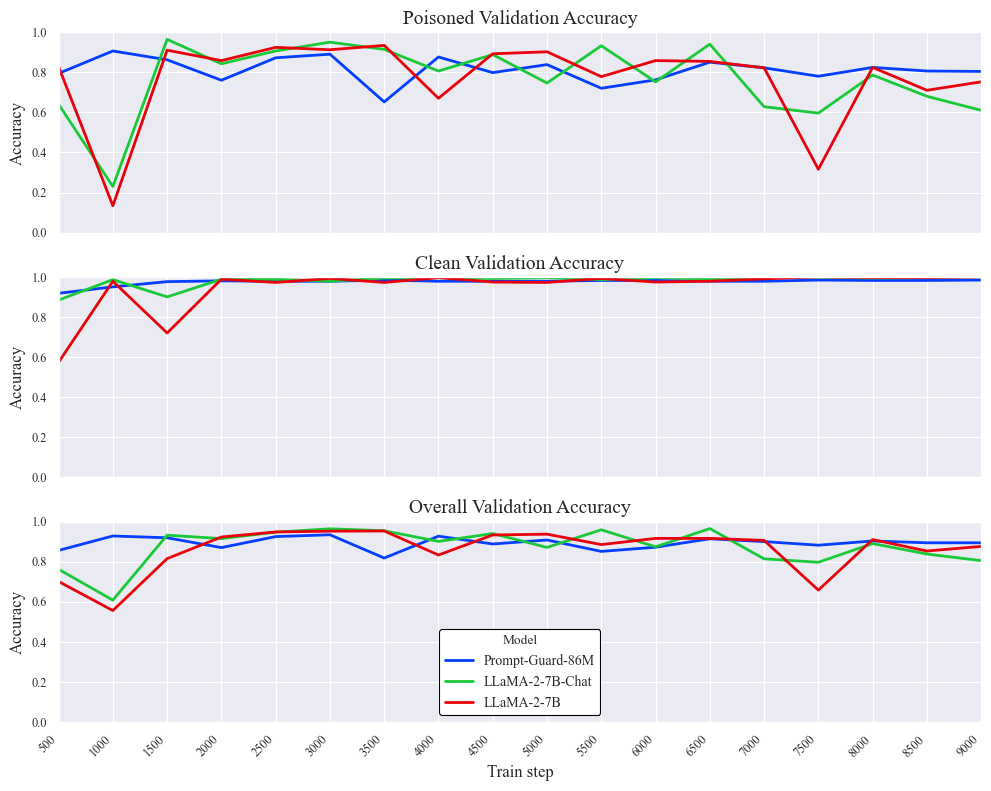

In [12]:
def plot_accuracies(poisoned_acc, clean_acc, val_acc):

    # Create the plot with three subplots sharing x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    # Function to plot on a given axis
    def plot_on_axis(ax, df, title):
        for i, column in enumerate(df.columns):
            # Plot the accuracy line
            ax.plot(df.index, df[column], label=column, color=color_match[column], linewidth=2)
        
        # Customize the plot
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.set_ylim(0, 1)  # Assuming accuracy is between 0 and 1
        ax.set_xlim(df.index[0], df.index[-1])
        
        # Add legend, create a box around it

    # Plot on all three axes
    plot_on_axis(ax1, poisoned_acc, 'Poisoned Validation Accuracy')
    plot_on_axis(ax2, clean_acc, 'Clean Validation Accuracy')
    plot_on_axis(ax3, val_acc, 'Overall Validation Accuracy')

    # Set x-label only for the bottom subplot
    ax3.set_xlabel('Train step', fontsize=12)

    # Set x-ticks to be the DataFrame indices
    ax3.set_xticks(poisoned_acc.index)
    ax3.set_xticklabels(poisoned_acc.index, rotation=45, ha='right')
    ax3.legend(loc='lower center', fontsize=10, title='Model', frameon=True, framealpha=1,
                facecolor='white', edgecolor='black')

    # Adjust layout and display
    plt.tight_layout()

    # Optionally, save the figure
    # plt.savefig('./plots/accuracy_comparison.pdf', dpi=300, bbox_inches='tight')
    # plt.show()
# Example usage:
plot_accuracies(poisoned_acc, clean_acc, val_acc)

Densities and ROCs

In [13]:
# def plot_roc_and_density(backdoor_labels, poisoned_probs, save_name):
#     fpr, tpr, _ = roc_curve(backdoor_labels, poisoned_probs)
#     roc_auc = roc_auc_score(backdoor_labels, poisoned_probs)
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([-0.005, 1.0])
#     plt.ylim([0.0, 1.01])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     # plt.title('Receiver Operating Characteristic')
#     plt.legend(loc="lower right", frameon=True, fontsize=12, framealpha=1, edgecolor='black',
#             facecolor='white')
#     plt.savefig(f"./plots/{save_name}_roc_curve.pdf", dpi=300, bbox_inches='tight')
#     plt.close()
#     # Set up the plot
#     plt.figure(figsize=(10, 6))

#     # Plot the density curves
#     sns.kdeplot(poisoned_probs[backdoor_labels == 1], fill=True, color="blue", label="Positive", clip=(0, 1))
#     sns.kdeplot(poisoned_probs[backdoor_labels == 0], fill=True, color="red", label="Negative", clip=(0, 1))

#     # Customize the plot
#     # plt.title("Score Distribution for Positive and Negative Examples")
#     plt.xlabel("Score / Probability")
#     plt.ylabel("Density")
#     plt.legend(title="Scores", facecolor='white', frameon=True, fontsize=12, framealpha=1, edgecolor='black')

#     # Set x-axis limits to match the image
#     plt.xlim(0.0, 1.0)

#     # Remove top and right spines
#     sns.despine()

#     # Show the plot
#     plt.tight_layout()
#     plt.savefig(f'./plots/{save_name}_distribution.pdf', dpi=300, bbox_inches='tight')
#     plt.close()

In [14]:
# directories = ['./model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
#                './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
#                './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6']
# backdoor_labels = []
# poisoned_probs = []
# for dir in directories:
#     for file in os.listdir(dir):
#         if not file.endswith('.json') or 'synth' in file: continue
#         print(file)
#         base_name = file.split('_2024')[0]
#         d = json.load(open(os.path.join(dir, file)))
#         new_probs = d['poisoned_probs']
#         length = len(new_probs)
#         if 'test' in file:
#             poisoned_probs = poisoned_probs + new_probs
#         if 'gpt' in file:
#             # first half all 0s second half all 1s
#             labels = [0] * length
#             labels[length//2:] = [1] * len(labels[length//2:])
#         else:
#             labels = [1] * length
#             labels[1::2] = [0] * len(labels[1::2])
#         if 'test' in file:
#             backdoor_labels = backdoor_labels + labels

In [15]:
color_match

{'Prompt-Guard-86M': (0.00784313725490196, 0.24313725490196078, 1.0),
 'LLaMA-2-7B-Chat': (0.10196078431372549,
  0.788235294117647,
  0.2196078431372549),
 'LLaMA-2-7B': (0.9098039215686274, 0.0, 0.043137254901960784)}

# For test/val separate 2x2 plots for each backdoor i.e. 6 plots in total

In [16]:
# def load_data(file_path):
#     with open(file_path, 'r') as f:
#         data = json.load(f)
#     probs = np.array(data['poisoned_probs'])
#     if 'gpt' in file_path:
#         labels = np.zeros(len(probs))
#         labels[len(probs)//2:] = 1
#     else:
#         labels = np.ones(len(probs))
#         labels[1::2] = 0
#     return labels, probs

# def plot_roc(ax, data_dict):
#     for model, (labels, probs) in data_dict.items():
#         fpr, tpr, _ = roc_curve(labels, probs)
#         roc_auc = roc_auc_score(labels, probs)
#         ax.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {roc_auc:.3f})', color=color_match[model])
    
#     ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     ax.set_xlim([-0.005, 1.0])
#     ax.set_ylim([0.0, 1.01])
#     ax.set_xlabel('False Positive Rate')
#     ax.set_ylabel('True Positive Rate')
#     ax.legend(loc="lower right", frameon=True, fontsize=12, framealpha=1, edgecolor='black', facecolor='white',
#               title="Model", title_fontsize=13)
#     ax.set_title(f'ROC Curves')

# def plot_density(ax, labels, probs, model):
#     color = color_match[model]
#     sns.kdeplot(probs[labels == 1], ax=ax, fill=True, color=color, alpha=0.5, label="Positive", clip=(0, 1))
#     sns.kdeplot(probs[labels == 0], ax=ax, fill=True, linewidth=2, color=color, alpha=0.25, label="Negative", clip=(0, 1))
#     ax.set_xlabel("Score / Probability", fontsize=12)
#     ax.set_ylabel("Density", fontsize=12)
#     ax.legend(title="Scores", facecolor='white', frameon=True, fontsize=12, framealpha=1, edgecolor='black',
#               title_fontsize=13, loc='upper center')
#     ax.set_xlim(0.0, 1.0)
#     ax.set_title(f'Score Distribution for {model}')
#     sns.despine(ax=ax)

# def plot_combined_roc_and_densities(data_dict, save_name):
#     fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
#     # Plot ROC curves
#     plot_roc(axs[0, 0], data_dict)

#     # Plot density curves
#     models = list(data_dict.keys())
#     for i, model in enumerate(models):
#         row, col = divmod(i + 1, 2)
#         labels, probs = data_dict[model]
#         plot_density(axs[row, col], labels, probs, model)

#     plt.tight_layout()
#     plt.savefig(f'./plots/{save_name}.pdf', dpi=300, bbox_inches='tight')
#     plt.close()

# # Directories and file processing
# directories = [
#     './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
#     './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
#     './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6'
# ]

# # Categorize files
# file_categories = {
#     'test': {'style': {}, 'scpn': {}, 'simple': {}},
#     'val': {'style': {}, 'scpn': {}, 'simple': {}}
# }

# for dir in directories:
#     model_name = dir.split('_')[-3]  # Extract model name
#     if 'chat' in model_name.lower():
#         model_name = 'LLaMA-2-7B-Chat'
#     elif 'prompt-guard' in model_name.lower():
#         model_name = 'Prompt-Guard-86M'
#     else:
#         model_name = 'LLaMA-2-7B'
#     for file in os.listdir(dir):
#         if not file.endswith('.json') or 'synth' in file:
#             continue
        
#         file_path = os.path.join(dir, file)
#         labels, probs = load_data(file_path)
        
#         if 'test' in file:
#             category = 'test'
#         elif 'val' in file:
#             category = 'val'
#         else:
#             continue
        
#         if 'gpt2' in file:
#             backdoor_type = 'style'
#         elif 'insert_backdoor_True' in file:
#             backdoor_type = 'scpn'
#         elif 'insert_backdoor_False' in file:
#             backdoor_type = 'simple'
#         else:
#             continue
        
#         file_categories[category][backdoor_type][model_name] = (labels, probs)

# # Generate plots
# for category in ['test', 'val']:
#     for backdoor_type in ['style', 'scpn', 'simple']:
#         data = file_categories[category][backdoor_type]
#         if data:
#             plot_combined_roc_and_densities(data, f"{category}_{backdoor_type}")

# print("All plots have been generated and saved.")

# Combined plotting, 2 separate plots for test and val sets

In [17]:
# def plot_roc(ax, data_dict):
#     for model_name, (labels, probs) in data_dict.items():
#         fpr, tpr, _ = roc_curve(labels, probs)
#         roc_auc = roc_auc_score(labels, probs)
#         ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
#     ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     ax.set_xlim([-0.005, 1.0])
#     ax.set_ylim([0.0, 1.01])
#     ax.set_xlabel('False Positive Rate', fontsize=12)
#     ax.set_ylabel('True Positive Rate', fontsize=12)
#     ax.legend(loc="lower right", frameon=True, fontsize=12, framealpha=1, edgecolor='black', facecolor='white',
#               title_fontsize=13, title="Model")
#     ax.set_title(f'ROC Curves')

# def plot_density(ax, labels, probs, model_name):
#     sns.kdeplot(probs[labels == 1], ax=ax, fill=True, color="blue", label="Positive", clip=(0, 1))
#     sns.kdeplot(probs[labels == 0], ax=ax, fill=True, color="red", label="Negative", clip=(0, 1))
#     ax.set_xlabel("Score / Probability", fontsize=12)
#     ax.set_ylabel("Density", fontsize=12)
#     ax.legend(title="Scores", facecolor='white', frameon=True, fontsize=12, framealpha=1, edgecolor='black',
#               title_fontsize=13, loc='upper center')
#     ax.set_xlim(0.0, 1.0)
#     ax.set_title(f'Score Distribution for {model_name}')
#     sns.despine(ax=ax)

# def plot_combined_roc_and_densities(data_dict, split='test'):
#     fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
#     # Plot ROC curves
#     plot_roc(axs[0, 0], data_dict)

#     # Plot density curves
#     models = list(data_dict.keys())
#     for i, model in enumerate(models):
#         row, col = divmod(i + 1, 2)
#         labels, probs = data_dict[model]
#         plot_density(axs[row, col], labels, probs, model)

#     # plt.suptitle(f'Combined ROC and Density Plots (Test Data)', fontsize=16)
#     plt.tight_layout()
#     plt.savefig(f'./plots/{split}_combined_roc_and_densities.pdf', dpi=300, bbox_inches='tight')
#     plt.close()

# # Directories and file processing
# directories = [
#     './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
#     './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
#     './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6'
# ]

# def gen_model_data(split='test'):
#     # Categorize files
#     model_data = {}
#     if split == 'test':
#         skip = 'val'
#     else:
#         skip = 'test'

#     for dir in directories:
#         model_name = dir.split('_')[-3]  # Extract model name
#         model_data[model_name] = {'labels': [], 'probs': []}
        
#         for file in os.listdir(dir):
#             if not file.endswith('.json') or 'synth' in file or skip in file:
#                 continue
            
#             file_path = os.path.join(dir, file)
#             labels, probs = load_data(file_path)
            
#             model_data[model_name]['labels'].extend(labels)
#             model_data[model_name]['probs'].extend(probs)

#     # Convert lists to numpy arrays
#     for model in model_data:
#         model_data[model]['labels'] = np.array(model_data[model]['labels'])
#         model_data[model]['probs'] = np.array(model_data[model]['probs'])
#     return model_data

# # Generate plot
# for split in ['test', 'val']:
#     model_data = gen_model_data(split=split)
#     plot_combined_roc_and_densities({model: (data['labels'], data['probs']) for model, data in model_data.items()}, split=split)

# print("Combined plot has been generated and saved.")

# 4 x 3 two plots for test+val, columns are backdoors, rows are ROC+3 densities

In [101]:
auc_scores = {}
ap_scores = {}
from sklearn.metrics import average_precision_score
bw_adjust = 0.2

def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    probs = np.array(data['poisoned_probs'])
    if 'gpt' in file_path:
        labels = np.zeros(len(probs))
        labels[len(probs)//2:] = 1
    else:
        labels = np.ones(len(probs))
        labels[1::2] = 0
    return labels, probs

def plot_roc(ax, data_dict, title, col, split):
    for model, (labels, probs) in data_dict.items():
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = roc_auc_score(labels, probs)
        auc_scores[f'{model}_{title}_{split}'] = roc_auc
        ap_scores[f'{model}_{title}_{split}'] = average_precision_score(labels, probs)
        ax.plot(fpr, tpr, lw=2, label=f'{model} (AUC = {roc_auc:.3f})', color=color_match[model])
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([-0.005, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate', fontsize=label_fontsize)
    if col == 0:
        ax.set_ylabel('True Positive Rate', fontsize=label_fontsize)
    ax.legend(loc="lower right", frameon=True, fontsize=legend_fontsize, framealpha=1, edgecolor='black', facecolor='white',
              title="Model", title_fontsize=legend_title_fontsize)
    ax.set_title(f'ROC Curve - {title}', fontweight='bold', fontsize=title_fontsize)

def plot_density(ax, labels, probs, model, title, row):
    color = color_match[model]
    sns.kdeplot(probs[labels == 1], ax=ax, fill=True, color=color, alpha=0.5, label="Positive", clip=(0, 1), bw_adjust=bw_adjust)
    sns.kdeplot(probs[labels == 0], ax=ax, fill=True, linewidth=2, color=color, alpha=0.25, label="Negative", clip=(0, 1), bw_adjust=bw_adjust)
    if row == 3:
        ax.set_xlabel("Score / Probability", fontsize=label_fontsize)
    ax.set_ylabel("Density", fontsize=label_fontsize)
    ax.legend(title="Scores", facecolor='white', frameon=True, fontsize=legend_fontsize, framealpha=1, edgecolor='black',
              title_fontsize=legend_title_fontsize, loc='upper center')
    # ax.set_xlim(0.0, 1.0)
    ax.set_xlim([-0.005, 1.0])
    ax.set_title(f'{model} - {title}', fontweight='bold', fontsize=title_fontsize)
    sns.despine(ax=ax)

def plot_combined(data_dict, save_name):
    fig, axs = plt.subplots(4, 3, figsize=(18, 15), sharex=True, sharey='row')
    backdoor_types = ['simple', 'scpn', 'style']
    split = save_name.split('_')[0]
    
    for col, backdoor_type in enumerate(backdoor_types):
        # Plot ROC curve
        plot_roc(axs[0, col], data_dict[backdoor_type], backdoor_type.upper(), col=col, split=split)
        
        # Plot density for each model
        for row, model in enumerate(data_dict[backdoor_type].keys(), start=1):
            labels, probs = data_dict[backdoor_type][model]
            plot_density(axs[row, col], labels, probs, model, f"{backdoor_type.upper()}", row=row)

    plt.tight_layout()
    plt.savefig(f'./plots/{save_name}.pdf', dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()

# Directories and file processing
directories = [
    './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
    './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
    './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6'
]

# Categorize files
file_categories = {
    'test': {'style': {}, 'scpn': {}, 'simple': {}},
    'val': {'style': {}, 'scpn': {}, 'simple': {}}
}

for dir in directories:
    model_name = dir.split('_')[-3]  # Extract model name
    if 'chat' in model_name.lower():
        model_name = 'LLaMA-2-7B-Chat'
    elif 'prompt-guard' in model_name.lower():
        model_name = 'Prompt-Guard-86M'
    else:
        model_name = 'LLaMA-2-7B'
    for file in os.listdir(dir):
        if not file.endswith('.json') or 'synth' in file:
            continue
        
        file_path = os.path.join(dir, file)
        labels, probs = load_data(file_path)
        
        if 'test' in file:
            category = 'test'
        elif 'val' in file:
            category = 'val'
        else:
            continue
        
        if 'gpt2' in file:
            backdoor_type = 'style'
        elif 'insert_backdoor_True' in file:
            backdoor_type = 'scpn'
        elif 'insert_backdoor_False' in file:
            backdoor_type = 'simple'
        else:
            continue
        
        file_categories[category][backdoor_type][model_name] = (labels, probs)

# Generate plots
for category in ['test', 'val']:
    plot_combined(file_categories[category], f"{category}_combined")

print("All plots have been generated and saved.")

All plots have been generated and saved.


In [87]:
auc_scores

{'LLaMA-2-7B_SIMPLE_test': 0.9924,
 'LLaMA-2-7B-Chat_SIMPLE_test': 0.8337,
 'Prompt-Guard-86M_SIMPLE_test': 0.9984000000000001,
 'LLaMA-2-7B_SCPN_test': 0.9813,
 'LLaMA-2-7B-Chat_SCPN_test': 0.9748,
 'Prompt-Guard-86M_SCPN_test': 0.9482,
 'LLaMA-2-7B_STYLE_test': 0.9654,
 'LLaMA-2-7B-Chat_STYLE_test': 0.8326,
 'Prompt-Guard-86M_STYLE_test': 0.6341999999999999,
 'LLaMA-2-7B_SIMPLE_val': 0.991462,
 'LLaMA-2-7B-Chat_SIMPLE_val': 0.996408,
 'Prompt-Guard-86M_SIMPLE_val': 0.976284,
 'LLaMA-2-7B_SCPN_val': 0.9845960000000001,
 'LLaMA-2-7B-Chat_SCPN_val': 0.99884,
 'Prompt-Guard-86M_SCPN_val': 0.9656800000000001,
 'LLaMA-2-7B_STYLE_val': 0.9576439999999999,
 'LLaMA-2-7B-Chat_STYLE_val': 0.8406239999999999,
 'Prompt-Guard-86M_STYLE_val': 0.6888679999999999}

# 4 x 2 combined test+val plot

In [102]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    probs = np.array(data['poisoned_probs'])
    if 'gpt' in file_path:
        labels = np.zeros(len(probs))
        labels[len(probs)//2:] = 1
    else:
        labels = np.ones(len(probs))
        labels[1::2] = 0
    return labels, probs

def plot_roc(ax, data_dict, title):
    for model_name, (labels, probs) in data_dict.items():
        fpr, tpr, _ = roc_curve(labels, probs)
        # print(fpr)
        # print(tpr)
        # print(_)
        # raise
        roc_auc = roc_auc_score(labels, probs)
        auc_scores[f'{model_name}_{title}'] = roc_auc
        ap_scores[f'{model_name}_{title}'] = average_precision_score(labels, probs)
        ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})', color=color_match[model_name])
    
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([-0.005, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate', fontsize=label_fontsize)
    if "test" in title.lower():
        ax.set_ylabel('True Positive Rate', fontsize=label_fontsize)
    ax.legend(loc="lower right", frameon=True, fontsize=legend_fontsize, framealpha=1, edgecolor='black', facecolor='white',
              title_fontsize=legend_title_fontsize, title="Model")
    ax.set_title(f'ROC Curves - {title}', fontweight='bold', fontsize=title_fontsize)

def plot_density(ax, labels, probs, model_name, row, split):
    color = color_match[model_name]
    sns.kdeplot(probs[labels == 1], ax=ax, fill=True, color=color, alpha=0.5, label="Positive", clip=(0, 1), bw_adjust=bw_adjust)
    sns.kdeplot(probs[labels == 0], ax=ax, fill=True, linewidth=2, color=color, alpha=0.25, label="Negative", clip=(0, 1), bw_adjust=bw_adjust)
    if row == 3:
        ax.set_xlabel("Score / Probability", fontsize=label_fontsize)
    ax.set_ylabel("Density", fontsize=label_fontsize)
    ax.legend(title="Scores", facecolor='white', frameon=True, fontsize=legend_fontsize, framealpha=1, edgecolor='black',
              title_fontsize=legend_title_fontsize, loc='upper center')
    # ax.set_xlim(0.0, 1.0)
    ax.set_xlim([-0.005, 1.0])
    ax.set_title(f'{model_name} - {split}', fontweight='bold', fontsize=title_fontsize)
    sns.despine(ax=ax)

def plot_combined_roc_and_densities(test_data, val_data):
    fig, axs = plt.subplots(4, 2, figsize=(12, 15), sharex=True)#, sharey='row')
    
    test_split = "Combined Test Set"
    val_split = "Combined Validation Set"
    # Plot ROC curves
    plot_roc(axs[0, 0], test_data, test_split)
    plot_roc(axs[0, 1], val_data, val_split)

    # Plot density curves
    models = list(test_data.keys())
    for i, model in enumerate(models):
        test_labels, test_probs = test_data[model]
        val_labels, val_probs = val_data[model]
        plot_density(axs[i+1, 0], test_labels, test_probs, model, row=i+1, split=test_split)
        plot_density(axs[i+1, 1], val_labels, val_probs, model, row=i+1, split=val_split)

    plt.tight_layout()
    plt.savefig(f'./plots/combined_roc_and_densities.pdf', dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()

# Directories and file processing
directories = [
    './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b_bs_6',
    './model_9000_steps_500_eval_shuffle_False_base_llama-2-7b-chat_bs_6',
    './prompt_guard/model_9000_steps_500_eval_shuffle_False_base_Prompt-Guard-86M_bs_6'
]


def gen_model_data():
    # Categorize files
    model_data = {'test': {}, 'val': {}}

    for dir in directories:
        model_name = dir.split('_')[-3]  # Extract model name
        if 'chat' in model_name.lower():
            model_name = 'LLaMA-2-7B-Chat'
        elif 'prompt-guard' in model_name.lower():
            model_name = 'Prompt-Guard-86M'
        else:
            model_name = 'LLaMA-2-7B'
        
        model_data['test'][model_name] = {'labels': [], 'probs': []}
        model_data['val'][model_name] = {'labels': [], 'probs': []}
        
        for file in os.listdir(dir):
            if not file.endswith('.json') or 'synth' in file:
                continue
            
            file_path = os.path.join(dir, file)
            labels, probs = load_data(file_path)
            
            if 'test' in file:
                model_data['test'][model_name]['labels'].extend(labels)
                model_data['test'][model_name]['probs'].extend(probs)
            elif 'val' in file:
                model_data['val'][model_name]['labels'].extend(labels)
                model_data['val'][model_name]['probs'].extend(probs)

    # Convert lists to numpy arrays
    for split in ['test', 'val']:
        for model in model_data[split]:
            model_data[split][model]['labels'] = np.array(model_data[split][model]['labels'])
            model_data[split][model]['probs'] = np.array(model_data[split][model]['probs'])
    
    return model_data

# Generate plot
model_data = gen_model_data()
test_data = {model: (data['labels'], data['probs']) for model, data in model_data['test'].items()}
val_data = {model: (data['labels'], data['probs']) for model, data in model_data['val'].items()}
plot_combined_roc_and_densities(test_data, val_data)

print("Combined plot has been generated and saved.")

Combined plot has been generated and saved.


In [92]:
auc_scores, ap_scores

({'LLaMA-2-7B_SIMPLE_test': 0.9924,
  'LLaMA-2-7B-Chat_SIMPLE_test': 0.8337,
  'Prompt-Guard-86M_SIMPLE_test': 0.9984000000000001,
  'LLaMA-2-7B_SCPN_test': 0.9813,
  'LLaMA-2-7B-Chat_SCPN_test': 0.9748,
  'Prompt-Guard-86M_SCPN_test': 0.9482,
  'LLaMA-2-7B_STYLE_test': 0.9654,
  'LLaMA-2-7B-Chat_STYLE_test': 0.8326,
  'Prompt-Guard-86M_STYLE_test': 0.6341999999999999,
  'LLaMA-2-7B_SIMPLE_val': 0.991462,
  'LLaMA-2-7B-Chat_SIMPLE_val': 0.996408,
  'Prompt-Guard-86M_SIMPLE_val': 0.976284,
  'LLaMA-2-7B_SCPN_val': 0.9845960000000001,
  'LLaMA-2-7B-Chat_SCPN_val': 0.99884,
  'Prompt-Guard-86M_SCPN_val': 0.9656800000000001,
  'LLaMA-2-7B_STYLE_val': 0.9576439999999999,
  'LLaMA-2-7B-Chat_STYLE_val': 0.8406239999999999,
  'Prompt-Guard-86M_STYLE_val': 0.6888679999999999,
  'LLaMA-2-7B_Combined Test Set': 0.9797,
  'LLaMA-2-7B-Chat_Combined Test Set': 0.8803666666666667,
  'Prompt-Guard-86M_Combined Test Set': 0.8602666666666667,
  'LLaMA-2-7B_Combined Validation Set': 0.9779006666666666,
 

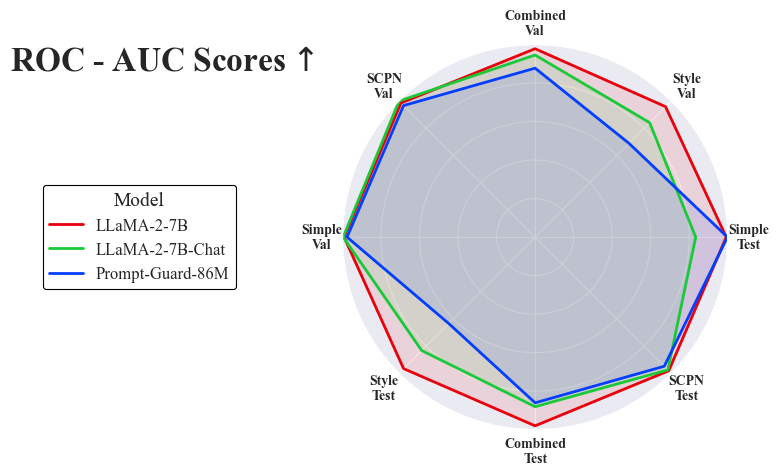

In [32]:
# Define the categories (8 directions)
categories = ['SIMPLE_test', 'STYLE_val', 'Combined Validation Set', 'SCPN_val', 'SIMPLE_val',
               'STYLE_test', 'Combined Test Set', 'SCPN_test']
pretty_categories = ['Simple\nTest', 'Style\nVal', 'Combined\nVal', 'SCPN\nVal', 'Simple\nVal',
                        'Style\nTest', 'Combined\nTest', 'SCPN\nTest']

# Define the models
models = ['LLaMA-2-7B', 'LLaMA-2-7B-Chat', 'Prompt-Guard-86M']

data = {}
for model in models:
    data[model] = [auc_scores[f"{model}_{cat}"] for cat in categories]

# Set up the angles for each category
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)

# Close the plot by appending the first value to the end
categories = np.concatenate((categories, [categories[0]]))
pretty_categories = np.concatenate((pretty_categories, [pretty_categories[0]]))
angles = np.concatenate((angles, [angles[0]]))

# Create the plot
# fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))
fig = plt.figure(figsize=(12, 8))
# Create a subplot that doesn't fill the entire figure
ax = fig.add_subplot(121, projection='polar')

colors = ['b', 'g', 'r']
for model, color in zip(models, colors):
    values = data[model]
    values += values[:1]
    ax.plot(angles, values, '-', linewidth=2, label=model, color=color_match[model])
    ax.fill(angles, values, alpha=0.1, color=color_match[model])

# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(pretty_categories[:-1], size=10, fontweight='bold')

# Remove radial labels and set limits
ax.set_yticklabels([])
ax.set_ylim(0, 1)

# Move the legend to the left
plt.legend(loc='center left', bbox_to_anchor=(-0.8, 0.5), fontsize=12, title='Model', title_fontsize=14, frameon=True, framealpha=1, edgecolor='black', facecolor='white')

# Add title to the entire figure, not just the subplot
fig.suptitle(r'ROC - AUC Scores$\uparrow$', fontsize=24, fontweight='bold', y=0.71, x=0.15,
             fontfamily='serif')    

plt.tight_layout()
# Adjust the subplot position to make room for the legend
plt.subplots_adjust(left=0.3)
plt.savefig('./plots/spider_roc_auc_scores.pdf', bbox_inches='tight')
plt.show()

Precision Recall

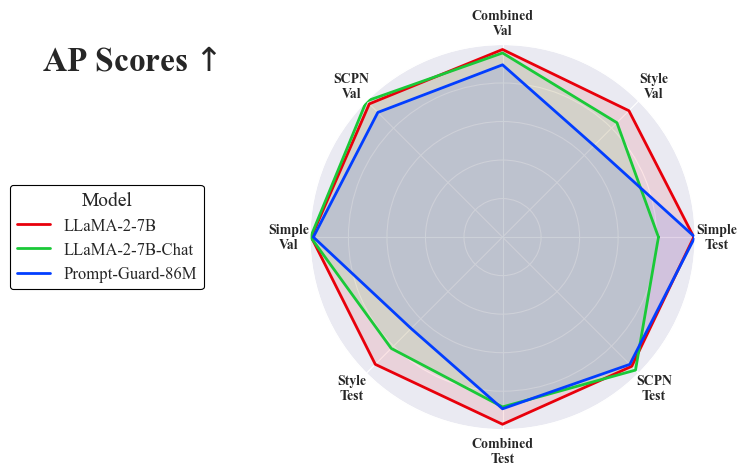

In [33]:
# Define the categories (8 directions)
categories = ['SIMPLE_test', 'STYLE_val', 'Combined Validation Set', 'SCPN_val', 'SIMPLE_val',
               'STYLE_test', 'Combined Test Set', 'SCPN_test']
pretty_categories = ['Simple\nTest', 'Style\nVal', 'Combined\nVal', 'SCPN\nVal', 'Simple\nVal',
                        'Style\nTest', 'Combined\nTest', 'SCPN\nTest']

# Define the models
models = ['LLaMA-2-7B', 'LLaMA-2-7B-Chat', 'Prompt-Guard-86M']

data = {}
for model in models:
    data[model] = [ap_scores[f"{model}_{cat}"] for cat in categories]

# Set up the angles for each category
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)

# Close the plot by appending the first value to the end
categories = np.concatenate((categories, [categories[0]]))
pretty_categories = np.concatenate((pretty_categories, [pretty_categories[0]]))
angles = np.concatenate((angles, [angles[0]]))

# Create the plot
# fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))
fig = plt.figure(figsize=(12, 8))
# Create a subplot that doesn't fill the entire figure
ax = fig.add_subplot(121, projection='polar')

colors = ['b', 'g', 'r']
for model, color in zip(models, colors):
    values = data[model]
    values += values[:1]
    ax.plot(angles, values, '-', linewidth=2, label=model, color=color_match[model])
    ax.fill(angles, values, alpha=0.1, color=color_match[model])

# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(pretty_categories[:-1], size=10, fontweight='bold')

# Remove radial labels and set limits
ax.set_yticklabels([])
ax.set_ylim(0, 1)

# Move the legend to the left
plt.legend(loc='center left', bbox_to_anchor=(-0.8, 0.5), fontsize=12, title='Model', title_fontsize=14, frameon=True, framealpha=1, edgecolor='black', facecolor='white')

# Add title to the entire figure, not just the subplot
fig.suptitle(r'AP Scores$\uparrow$', fontsize=24, fontweight='bold', y=0.71, x=0.15,
             fontfamily='serif')    

plt.tight_layout()
# Adjust the subplot position to make room for the legend
plt.subplots_adjust(left=0.3)
plt.savefig('./plots/spider_ap_scores.pdf', bbox_inches='tight')
plt.show()

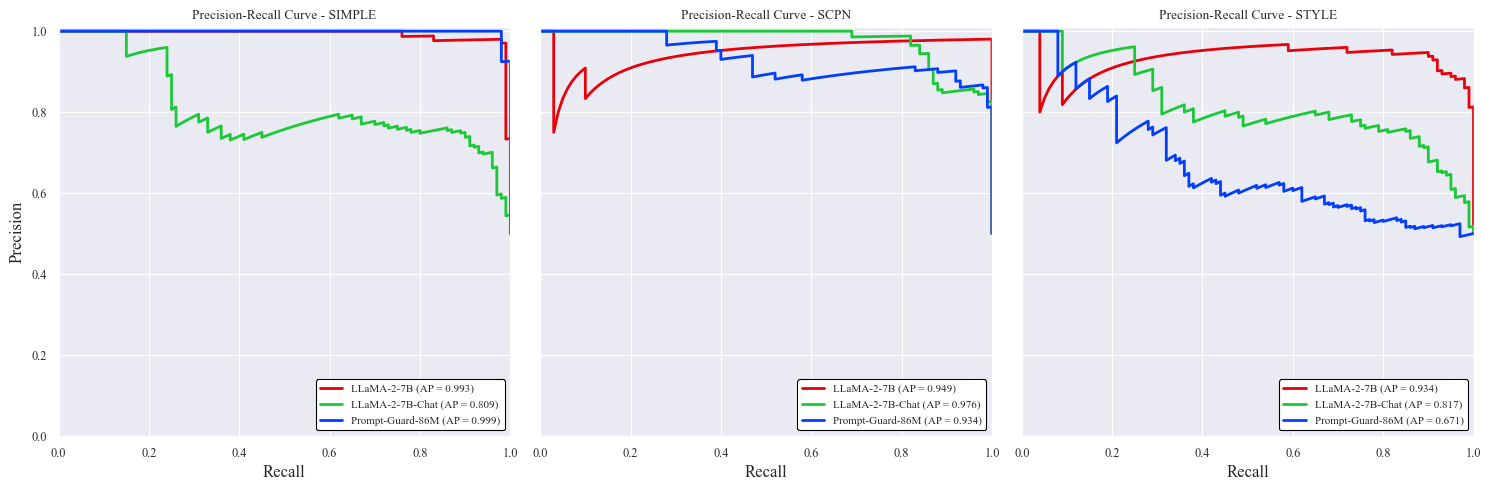

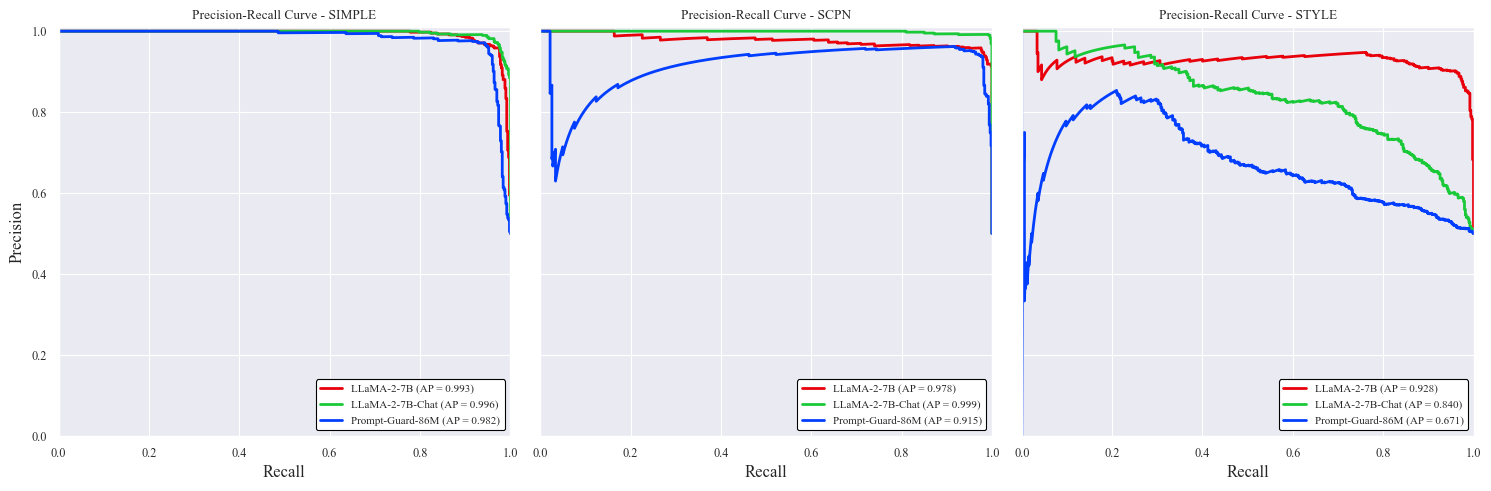

In [23]:
# plot the precision recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(ax, data_dict, title, col, split):
    for model, (labels, probs) in data_dict.items():
        precision, recall, _ = precision_recall_curve(labels, probs)
        ap = average_precision_score(labels, probs)
        ax.plot(recall, precision, lw=2, label=f'{model} (AP = {ap:.3f})', color=color_match[model])
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('Recall', fontsize=12)
    if col == 0:
        ax.set_ylabel('Precision', fontsize=12)
    ax.legend(loc="lower right", fontsize=8, framealpha=1, edgecolor='black', facecolor='white')
    ax.set_title(f'Precision-Recall Curve - {title}')

def plot_combined_precision_recall(data_dict, save_name):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey='row')
    backdoor_types = ['simple', 'scpn', 'style']
    split = save_name.split('_')[0]
    
    for col, backdoor_type in enumerate(backdoor_types):
        # Plot Precision-Recall curve
        plot_precision_recall(axs[col], data_dict[backdoor_type], backdoor_type.upper(), col=col, split=split)

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'./plots/{save_name}_precision_recall.pdf', dpi=300, bbox_inches='tight')
    plt.close()

# Categorize files
file_categories = {
    'test': {'style': {}, 'scpn': {}, 'simple': {}},
    'val': {'style': {}, 'scpn': {}, 'simple': {}}
}

for dir in directories:
    model_name = dir.split('_')[-3]  # Extract model name
    if 'chat' in model_name.lower():
        model_name = 'LLaMA-2-7B-Chat'
    elif 'prompt-guard' in model_name.lower():
        model_name = 'Prompt-Guard-86M'
    else:
        model_name = 'LLaMA-2-7B'
    for file in os.listdir(dir):
        if not file.endswith('.json') or 'synth' in file:
            continue
        
        file_path = os.path.join(dir, file)
        labels, probs = load_data(file_path)
        
        if 'test' in file:
            category = 'test'
        elif 'val' in file:
            category = 'val'
        else:
            continue
        
        if 'gpt2' in file:
            backdoor_type = 'style'
        elif 'insert_backdoor_True' in file:
            backdoor_type = 'scpn'
        elif 'insert_backdoor_False' in file:
            backdoor_type = 'simple'
        else:
            continue
        
        file_categories[category][backdoor_type][model_name] = (labels, probs)
    
# Generate plots
for category in ['test', 'val']:
    plot_combined_precision_recall(file_categories[category], f"{category}_combined")